In [1]:
# library to ignore warning
import warnings
warnings.simplefilter("ignore")


#libraries for data wrangling and visualization
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import plot,init_notebook_mode, plot, iplot
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
init_notebook_mode(connected=True)

#libraries to perform statistical tests
from statsmodels.tsa.stattools import adfuller
from timeseriesplots import timeseriesplots
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

#libraries for acf and pacf plots
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#libraries for forecasting
from arima import arima
from sarima import sarima
from ucm import ucm

%matplotlib inline

In [2]:
#making list of exogeneous variables for multivariate forecasting
exog_list = ['trend_rate','Positive economic event','Negative economic event','Political event']
# storing the dependent variable name in value
value = 'Nickel 3M Seller Price(USD/tonne)'

### Univariate Analysis

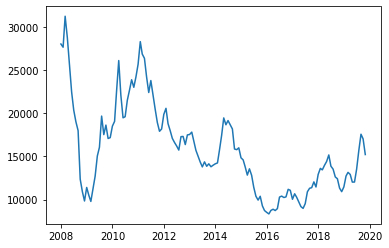

In [3]:
#loading univariate data from Nickel_forecast_latest.csv file
Nickel_univariate_df = pd.read_csv('Nickel_Multivariate_data.csv')
#converting "Date" column to datetime format and setting it as index
Nickel_univariate_df['Date'] = pd.to_datetime(Nickel_univariate_df['Date'],format='%m/%d/%Y')
Nickel_univariate_df.set_index('Date',inplace=True)
#visual plot of Nickel Price across time
plt.plot(Nickel_univariate_df[value])

In [4]:
#function to check whether series is stationary or not by performing augmented Dickey–Fuller test by taking series as input
def adf_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [5]:
#function to plot auto correlation plot and partial autocorrelation plot
def plot_acf_pacf(X):
    plot_acf(X)
    plt.show()
    plot_pacf(X)
    plt.show()

In [6]:
# Checking whether series is stationary or not
adf_test(Nickel_univariate_df[value])
# p-value is less than 0.05, which tells series is stationary, but greater than 5% critical value. Hence series is not perfectly stationary.

ADF Statistic: -2.866816
p-value: 0.049345
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


In [7]:
# Differencing the series to make stationary
Nickel_price_diff = Nickel_univariate_df[value].diff()
Nickel_price_diff.dropna(inplace=True)

In [8]:
adf_test(Nickel_price_diff.values)
# p-value is significantly lower than 0.05 and lesser than all critical values. Hence series is stationary

ADF Statistic: -8.949118
p-value: 0.000000
Critical Values:
	1%: -3.478
	5%: -2.882
	10%: -2.578


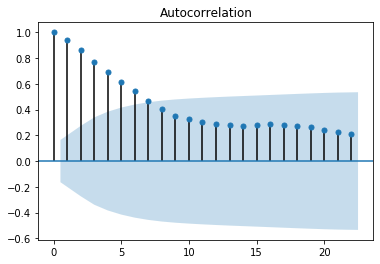

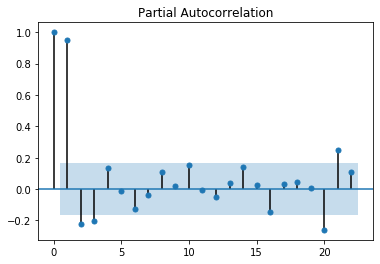

In [9]:
# ACF and PACF plots to find p and q values respectively
plot_acf_pacf(Nickel_univariate_df[value])

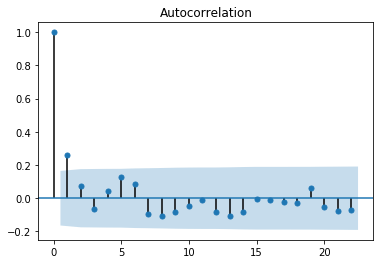

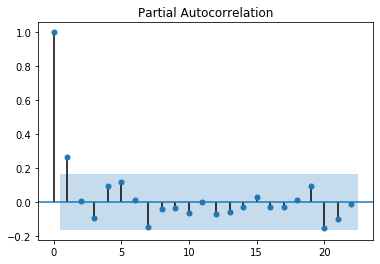

In [10]:
#ACF and PACF plots of differentiated series to find p and q values
plot_acf_pacf(Nickel_price_diff)

### Series Decomposition

In [11]:
# Series deompositon using stl function to understand nature of series by taking as dataframe as an argument
def series_decomposition(df,dep_var):
    #Breaking the series into trend, seasonality and irregularity compents
    trend,seasonality,irregularity = df.timeseriesplots.stl(dep_var,model='additive',filt=None,freq=None,two_sided=True,extrapolate_trend=0)
    trendFigure, seasonalityFigure, irregularityFigure = df.timeseriesplots.stlFigure(trend,seasonality,irregularity)
    # Visual Plots of components of series
    iplot(trendFigure)
    iplot(seasonalityFigure)
    iplot(irregularityFigure)

In [12]:
series_decomposition(Nickel_univariate_df[[value]],value)

### Spliting datasets into train and test based on time

In [13]:
Nickel_train_1yr = Nickel_univariate_df[[value]][Nickel_univariate_df.index<'01-01-2019']
Nickel_test_1yr = Nickel_univariate_df[[value]][Nickel_univariate_df.index>='01-01-2019']
Nickel_train_2yr = Nickel_univariate_df[[value]][Nickel_univariate_df.index<'01-01-2018']
Nickel_test_2yr = Nickel_univariate_df[[value]][Nickel_univariate_df.index>='01-01-2018']

### Accuracy Metric Calculation

In [14]:
# Function to calculate different accuracy metrics by passing forecasted series and actual series as an arguments and returns
# results dictionary
def forecast_accuracy(forecast, actual):
    results = dict()
    results['mape'] = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    results['me'] = np.mean(forecast - actual)             # ME
    results['mae'] = np.mean(np.abs(forecast - actual))    # MAE
    results['mpe'] = np.mean((forecast - actual)/actual)   # MPE
    results['rmse'] = np.mean((forecast - actual)**2)**.5  # RMSE
    return results

### Arima Model

In [15]:
#Building arima model for two different datasets with (p,d,q) order of (1,0,1)
arimaModel_1yr = Nickel_train_1yr.arima.build(value, order = (1,0,1))
arimaModel_2yr = Nickel_train_2yr.arima.build(value, order = (1,0,1))
#Forecasting the prices for known
arimaDfTest_1yr = Nickel_test_1yr.arima.scoreTest(arimaModel_1yr, value)
arimaDfTest_2yr = Nickel_test_2yr.arima.scoreTest(arimaModel_2yr, value)
#Calcualtion of different metrics for actual and forecasted prices
result_arima_1yr = forecast_accuracy(arimaDfTest_1yr['predicted'], arimaDfTest_1yr[value])
result_arima_2yr = forecast_accuracy(arimaDfTest_2yr['predicted'], arimaDfTest_2yr[value])
print(result_arima_1yr['mape'],result_arima_2yr['mape'])

0.12322207554052883 0.11923276851243494


### Arima model future value forecast

In [16]:
# forecasting future unknown values using entire data
arimaModel = Nickel_univariate_df.arima.build(value, order = (1,0,1))
arima_fc, arima_se, arima_conf = arimaModel.forecast(24)
future_value = dict()
#saving unknown forecasted values in "future_value" dictionary
future_value['arima'] = arima_fc

### Sarima model

In [17]:
#Building sarima model for two different datasets with (p,d,q) order of (1,0,1) and (P,D,Q,S) order of (0,1,0,12)
sarimaModel_1yr = Nickel_train_1yr.sarima.build(value, order = (1,0,1), seasonal_order = (0,1,0,12))
sarimaModel_2yr = Nickel_train_2yr.sarima.build(value, order = (1,0,1), seasonal_order = (0,1,0,12))
#Forecasting the prices for known values
sarimaDfTest_1yr = Nickel_test_1yr.sarima.scoreTest(sarimaModel_1yr, value)
sarimaDfTest_2yr = Nickel_test_2yr.sarima.scoreTest(sarimaModel_2yr, value)
#Calcualtion of different metrics for actual and forecasted prices
result_sarima_1yr = forecast_accuracy(sarimaDfTest_1yr['predicted'], sarimaDfTest_1yr[value])
result_sarima_2yr = forecast_accuracy(sarimaDfTest_2yr['predicted'], sarimaDfTest_2yr[value])
print(result_sarima_1yr['mape'],result_sarima_2yr['mape'])

0.14765028966542595 0.222037830588143


### Sarima model future value forecast

In [18]:
# forecasting future unknown values using entire data
sarimaModel = Nickel_univariate_df.sarima.build(value, order = (1,0,1),seasonal_order = (0,1,0,12))
sarima_fc= sarimaModel.forecast(24)
#saving unknown forecasted values in "future_value" dictionary
future_value['sarima'] = sarima_fc.values

### UCM model

In [19]:
#UCM univariate functions forecasts and caluculates different accuracy metrics by taking training and test data sets as arguments
def train_testsplit_UCM_univariate(train,test_1,dep_var):
    #making duplicates to avoid modifications original data sets
    train_df = train.copy(deep=True)
    test_df = test_1.copy(deep=True)
    # reducing the scale of prices by 100 to achieve better forecast of UCM model
    train_df[dep_var] = train_df[dep_var]/100
    #making duplicate training data set which will be updating after each forecast
    train_df_temp = train_df.copy(deep=True)
    test_len = len(test_df)
    
    ucmModel = train_df.ucm.build(dep_var, level='rwalk', trend=True,seasonal=12, stochastic_seasonal=False, cycle= False,autoregressive = 1, irregular=True, maxiter=10)
    test = pd.DataFrame(ucmModel.forecast(min(test_len,3)),columns=[dep_var])
    
    test_len = test_len - min(test_len,3)
    
    #forecasted values are appended to training dataset to retrain the model on updated training set 
    train_df = pd.concat([train_df,test])
    
    while(test_len!=0):
        ucmModel = train_df.ucm.build(dep_var, level='rwalk', trend=True,stochastic_seasonal=False,seasonal=12,  cycle= False,autoregressive = 1, irregular=True, maxiter=10)
        
        test_temp = pd.DataFrame(ucmModel.forecast(min(test_len,3)),columns=[dep_var])
        test_len = test_len - min(test_len,3)
        
        train_df = pd.concat([train_df,test_temp])
        test = pd.concat([test,test_temp])
    #forecasted values are multiplied by 100 to reach original scale    
    test[dep_var] = test[dep_var]*100
    # Calculating different metrics and return it as dictionary
    result = forecast_accuracy(test[dep_var],test_df[dep_var])
    return result

### Calculating MAPE for 1 year and 2 year using UCM

In [20]:
result_UCM_1yr = train_testsplit_UCM_univariate(Nickel_train_1yr,Nickel_test_1yr,value)
result_UCM_2yr = train_testsplit_UCM_univariate(Nickel_train_2yr,Nickel_test_2yr,value)

### UCM model future value forecast

In [21]:
#Copying the data to avoid modifications in original data set
Nickel_UCM_future = Nickel_univariate_df[[value]].copy(deep=True)
#training the model
Nickel_UCM_future[value] = Nickel_UCM_future[value]
ucmModel = Nickel_UCM_future.ucm.build(value, level='rwalk', trend=True,seasonal=12, stochastic_seasonal=False, cycle= False,autoregressive = 1, irregular=True, maxiter=10)
#forecasting the values for next 24 with step of 3
final_out = pd.DataFrame(ucmModel.forecast(3),columns=[value])
Nickel_UCM_future = pd.concat([Nickel_UCM_future,final_out],ignore_index=False)
for i in range(7):
    ucmModel = Nickel_UCM_future.ucm.build(value, level='rwalk', trend=True,seasonal=12, stochastic_seasonal=False, cycle= False,autoregressive = 1, irregular=True, maxiter=10)
    test_temp = pd.DataFrame(ucmModel.forecast(3),columns=[value])
    Nickel_UCM_future = pd.concat([Nickel_UCM_future,test_temp],ignore_index=False)
    final_out = pd.concat([final_out,test_temp],ignore_index=False)
#saving the future forecasted values in dictionary
future_value['UUCM'] = final_out.values.flatten()

### Multivariate Analysis

In [22]:
Nickel_multivariate = pd.read_csv('Nickel_Multivariate_data.csv')
Nickel_multivariate['Date'] = pd.to_datetime(Nickel_multivariate['Date'],format='%m/%d/%Y')
Nickel_multivariate.set_index('Date',inplace=True)
Nickel_multivariate.head()

,Nickel 3M Seller Price(USD/tonne),Coal price (USD/tn),Crude Oil(USD),USD_to_IDR,Lme_Nickel_stock(tonne),eur_to_USD,US_dollar_index,trend_rate,Positive economic event,Political event,Google trend,Negative economic event
Date,,,,,,,,,,,,
2008-01-01,27997.73,200.0,92.7236,9246.5,47122,1.4866,75.285,0,0,0,0,1
2008-02-01,27626.07,330.0,95.8200,9065.0,46948,1.5181,73.750,0,0,0,0,1
2008-03-01,31208.68,350.0,104.3000,9215.0,46861,1.5774,72.165,0,0,0,0,1
2008-04-01,28748.64,380.0,109.6200,9222.0,46768,1.5617,72.720,0,0,0,0,1
2008-05-01,25722.75,385.0,120.7000,9315.0,46678,1.5554,72.950,0,0,0,0,1


### Splitting the data into train and test

In [23]:
Nickel_mtrain_1yr = Nickel_multivariate[Nickel_multivariate.index<'01-01-2019']
Nickel_mtest_1yr = Nickel_multivariate[Nickel_multivariate.index>='01-01-2019']
Nickel_mtrain_2yr = Nickel_multivariate[Nickel_multivariate.index<'01-01-2018']
Nickel_mtest_2yr = Nickel_multivariate[Nickel_multivariate.index>='01-01-2018']

### ARIMAX

In [24]:
#making list of exogeneous variables for multivariate forecasting
exog_list = ['trend_rate','Positive economic event','Negative economic event','Political event']
# storing the dependent variable name in value
value = 'Nickel 3M Seller Price(USD/tonne)'

#training the model for 1year and 2 year forecast
arimaxModel_1yr = Nickel_mtrain_1yr.arima.build(value,exog= Nickel_mtrain_1yr[exog_list],order = (1,0,1))
arimaxModel_2yr = Nickel_mtrain_2yr.arima.build(value,exog= Nickel_mtrain_2yr[exog_list],order = (1,0,1))

#forecasting known values
arimax_test_1yr, arimax_se_1yr, arimax_conf_1yr = arimaxModel_1yr.forecast(len(Nickel_mtest_1yr),exog= Nickel_mtest_1yr[exog_list])
arimax_test_2yr, arimax_se_2yr, arimax_conf_2yr = arimaxModel_2yr.forecast(len(Nickel_mtest_2yr),exog= Nickel_mtest_2yr[exog_list])
#creating data frame for forecasted values
arimax_test_1yr = pd.DataFrame(arimax_test_1yr,columns=['Predict'],index=Nickel_mtest_1yr.index)
arimax_test_2yr = pd.DataFrame(arimax_test_2yr,columns=['Predict'],index=Nickel_mtest_2yr.index)

# calculating mape
result_arimax_1yr = forecast_accuracy(arimax_test_1yr['Predict'], Nickel_mtest_1yr[value])
result_arimax_2yr = forecast_accuracy(arimax_test_2yr['Predict'], Nickel_mtest_2yr[value])

print(result_arimax_1yr['mape'],result_arimax_2yr['mape'])

0.14741785693962361 0.10845015870567583


### ARIMAX forecast future

In [25]:
# data which contains list of future exogeneous variables, since future flags are unknown, we are assuming to be zeros
exog_future = np.zeros((24,4),dtype=float)
arimaxModel = Nickel_multivariate.arima.build(value,exog= Nickel_multivariate[exog_list],order = (1,0,1))
arimax_forecast, arimax_se,arimax_conf = arimaxModel.forecast(24,exog=exog_future)
future_value['arimax'] = arimax_forecast

### SARIMAX

In [26]:
#building sarima model
sarimaxModel_1yr = Nickel_mtrain_1yr.sarima.build(value,exog= Nickel_mtrain_1yr[exog_list],order = (1,0,1),seasonal_order = (0,1,0,12))
sarimaxModel_2yr = Nickel_mtrain_2yr.sarima.build(value,exog= Nickel_mtrain_2yr[exog_list],order = (1,0,1),seasonal_order = (0,1,0,12))
#forecasting known values
sarimax_test_1yr = sarimaxModel_1yr.forecast(len(Nickel_mtest_1yr),exog= Nickel_mtest_1yr[exog_list])
sarimax_test_2yr = sarimaxModel_2yr.forecast(len(Nickel_mtest_2yr),exog= Nickel_mtest_2yr[exog_list])
#saving in dataframe 
sarimax_test_1yr = pd.DataFrame(sarimax_test_1yr,columns=['Predict'],index=Nickel_mtest_1yr.index)
sarimax_test_2yr = pd.DataFrame(sarimax_test_2yr,columns=['Predict'],index=Nickel_mtest_2yr.index)
#calculating mape
result_sarimax_1yr = forecast_accuracy(sarimax_test_1yr['Predict'], Nickel_mtest_1yr[value])
result_sarimax_2yr = forecast_accuracy(sarimax_test_2yr['Predict'], Nickel_mtest_2yr[value])

print(result_sarimax_1yr['mape'],result_sarimax_2yr['mape'])

0.1482385238300783 0.22716519125081608


### SARIMAX forecast future

In [27]:
sarimaxModel = Nickel_multivariate.sarima.build(value,exog= Nickel_multivariate[exog_list],order = (1,0,1))
sarimax_forecast = sarimaxModel.forecast(24,exog=exog_future)
future_value['sarimax'] = sarimax_forecast.values

### UCM Multivariate

In [28]:
#UCM_multivariate function takes train data,test data, dependent variable and exogeneous variable list and returns 
# accuracy
def UCM_multivariate(train_data,test_data,depend_var,exogeneous_list):
    train_df = train_data.copy(deep=True)
    test_df = test_data.copy(deep=True)
    train_df[depend_var] =  train_df[depend_var]/100
    ucmModel = train_df.ucm.build(depend_var,exog= train_df[exogeneous_list],level='rwalk',trend=True,seasonal=12, stochastic_trend=False, cycle= False,autoregressive = 1, irregular=True, maxiter=10)
    preidct = pd.DataFrame(ucmModel.forecast(len(test_df),exog=test_df[exog_list])*100,columns=['Predict'])
    result = forecast_accuracy(preidct['Predict'], test_df[depend_var])
    return result

In [29]:
result_MUCM_1yr = UCM_multivariate(Nickel_mtrain_1yr,Nickel_mtest_1yr,value,exog_list)
result_MUCM_2yr = UCM_multivariate(Nickel_mtrain_2yr,Nickel_mtest_2yr,value,exog_list)

### UCM Multivariate forecast

In [30]:
ucm_multivariate_df = Nickel_multivariate.copy(deep=True)
ucm_multivariate_df[value] = ucm_multivariate_df[value]/100
MUCMModel = ucm_multivariate_df.ucm.build(value,exog= Nickel_multivariate[exog_list],level='rwalk',trend=True,seasonal=12, stochastic_trend=False, cycle= False,autoregressive = 1, irregular=True, maxiter=10)
MUCM_forecast = MUCMModel.forecast(24,exog=exog_future)*100
future_value['MUCM'] = MUCM_forecast.values

In [31]:
future_index = pd.date_range(start='12/1/2019',freq='MS',periods=24)
#saving all future forecasted values in data frame
future_df = pd.DataFrame.from_dict(future_value)
future_df.set_index(future_index,inplace=True)

In [32]:
future_df.head()

,arima,sarima,UUCM,arimax,sarimax,MUCM
2019-12-01,14903.797664,14128.029447,15315.280552,14805.946942,14888.212808,15370.402815
2020-01-01,15001.469450,14093.423755,15829.495237,14847.868329,14796.438351,15719.357248
2020-02-01,15094.894018,14877.527862,16225.013221,14888.102675,14705.229613,16216.254965
2020-03-01,15184.256057,14904.598923,16456.556133,14926.717873,14614.583108,16654.037928
2020-04-01,15269.732225,14344.398447,16568.537721,14963.779082,14524.495369,16808.141615


In [33]:
#TO store forecasted values of different method to csv
#future_df.to_csv('Forecasted_values.csv')